In [4]:
!pip install PyPDF2
!pip install matplotlib
!pip install textract
!pip install tkPDFViewer

In [1]:
import PyPDF2
import os
import textract
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def statistics(candidate):
    pdfFileObj = open(f'resumes/{candidate}','rb')

    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

    num_pages = pdfReader.numPages

    count = 0

    text = ""

    while count < num_pages:
        pageObj = pdfReader.getPage(count)
        count +=1
        text += pageObj.extractText()
    
    text = text.lower()

    text = re.sub(r'\d+','',text)

    text = text.translate(str.maketrans('','',string.punctuation))

    terms = {'Project management':['administration','agile','budget','cost','direction','feasibility analysis',
                                  'finance','kanban','leader','leadership','management','milestones','planning',
                                  'pmi','pmp','problem','project','risk','schedule','scrum','stakeholders'],
            'Data analytics':['analytics','api','aws','big data','busines intelligence','clustering','code',
                              'coding','data','database','data mining','data science','deep learning','hadoop',
                              'hypothesis test','iot','internet','machine learning','modeling','nosql','nlp',
                              'predictive','programming','python','r','sql','tableau','text mining',
                              'visualuzation'],
            'Healthcare':['adverse events','care','clinic','cphq','ergonomics','healthcare',
                          'health care','health','hospital','human factors','medical','near misses',
                          'patient','reporting system']}

    project = 0
    data = 0
    healthcare = 0

    scores = []

    for area in terms.keys():

        if area == 'Project management':
            for word in terms[area]:
                if word in text:
                    project +=1
            scores.append(project)

        elif area == 'Data analytics':
            for word in terms[area]:
                if word in text:
                    data +=1
            scores.append(data)

        else:
            for word in terms[area]:
                if word in text:
                    healthcare +=1
            scores.append(healthcare)

    summary = pd.DataFrame(scores,index=terms.keys(),columns=['score']).sort_values(by='score',ascending=False)

    pie = plt.figure(figsize=(4,5))
    plt.pie(summary['score'], labels=summary.index, explode = (0.1,0,0), autopct='%1.0f%%',shadow=True,startangle=90)
    plt.title('Summary')
    plt.axis('equal')
    plt.show()
    pie.savefig(f'/Users/pallavisharma/Desktop/untitled folder/results/{candidate}')
    
    return summary


In [2]:
path='/Users/pallavisharma/Desktop/untitled folder/resumes'
score_list=[]
name_list=[]
shorlisted=[]

def largest(list1, N):
    index_list=[]
    list2=list1
    for i in range(0, N):
        max1 = 0
        for j in range(len(list2)):    
            if list2[j] > max1:
                max1 = list2[j];
        list2.remove(max1);
        index_list.append(i)
    return index_list

def screening():
    for filename in os.listdir(path):
        name_list.append(filename)
        summary=statistics(filename)
        print(summary)
        t=summary.sum(axis = 0).to_frame()
        score_list.append(t.iat[0,0])
    shortlisted = [name_list[i] for i in largest(score_list,2)]
    return shortlisted


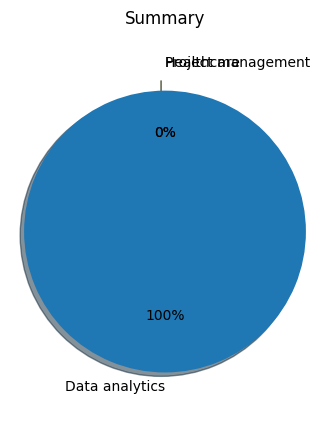

                    score
Data analytics          7
Project management      0
Healthcare              0


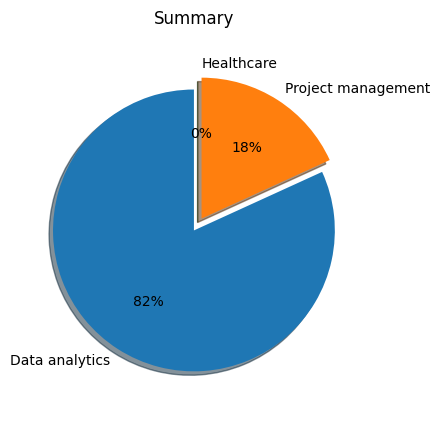

                    score
Data analytics          9
Project management      2
Healthcare              0


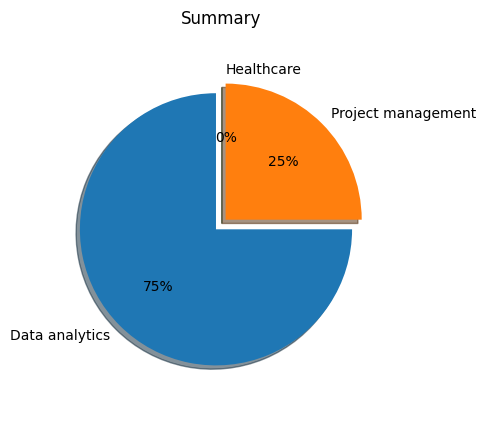

                    score
Data analytics          3
Project management      1
Healthcare              0
['Pallavi Sharma Resume.pdf', 'Kushal Resume.pdf']


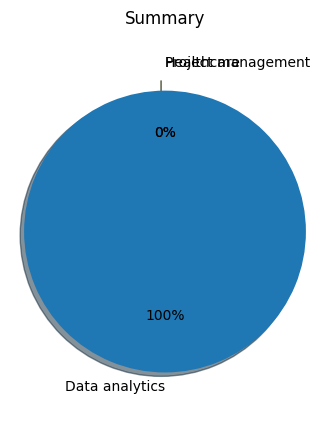

                    score
Data analytics          7
Project management      0
Healthcare              0


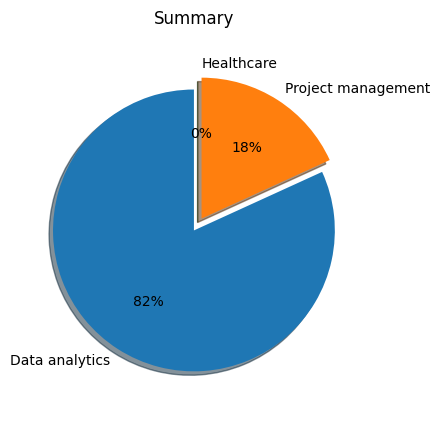

                    score
Data analytics          9
Project management      2
Healthcare              0


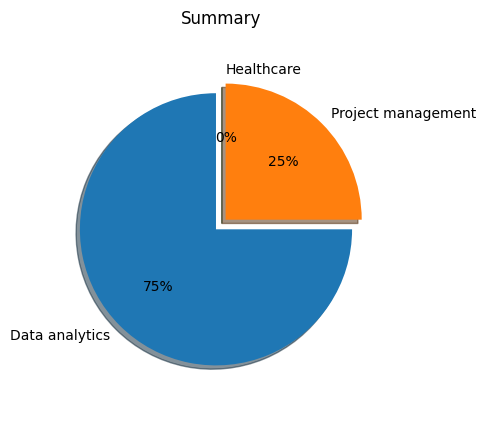

                    score
Data analytics          3
Project management      1
Healthcare              0
['Pallavi Sharma Resume.pdf', 'Kushal Resume.pdf']


In [3]:
from tkinter import *  

path2='/Users/pallavisharma/Desktop/untitled folder/results'

def display():
    
    top = Toplevel(root)

    top.title("SUMMARY")
    top.geometry("500x500")
    shortlist=screening()
    print(shortlist)
    label1 = Label(top, text = "SHORTLISTED CANDIDATES")
    label1.pack()
    for name in shortlist:
        label = Label(top, text = name.split("Resume.pdf")[0])
        label.pack()
    
    top.mainloop()
    
root = Tk()

root.title("PROFILE SCREENING")

root.geometry("500x500")

label1 = Label(root, text = "AI can help solve the biggest problem")
label2 = Label(root, text =  "of talent acquisition using")
label3 = Label(root, text =  "AI profile screening technology")

button = Button(root, text = "continue",command = display)

label1.pack()
label2.pack()
label3.pack()

button.pack()

root.mainloop()


